#### IMPORTS AND GLOBAL VARIABLES

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import requests
from shapely.geometry import Point, Polygon, LineString
import pandas as pd
import json
import geojson

WWA_APIKEY = 'b5833d39-a485-48c4-8058-40e0209c8eeb'



#### FUNCTIONS

In [90]:
def getReqSaveToJSON(url, filepath):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            data = data['result']
            # Save the AED data to a JSON file
            with open(filepath, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)
        else:
            print('Error:', response.status_code)
    except requests.exceptions.RequestException as e:
        print('Error:', e)

In [95]:
def process_feature_enom(feature):
    # Extract coordinates
    coords = [(float(p['longitude']), float(p['latitude'])) 
             for p in feature['geometry']['coordinates']]
    
    # Create polygon
    polygon = Polygon(coords)
    
    # Transform properties from key-value pairs to dictionary
    props = {}
    for prop in feature['properties']:
        props[prop['key']] = prop['value']
    
    return polygon, props


In [102]:
def create_geodataframe_enom(json_file):
    # Read JSON
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    polygons = []
    properties = []
    
    # Process each feature
    for feature in data['featureMemberList']:
        polygon, props = process_feature_enom(feature)
        polygons.append(polygon)
        properties.append(props)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        properties,
        geometry=polygons,
        crs="EPSG:4326"
    )
    
    return gdf

In [120]:
def process_feature_broutes(feature):
    # Extract coordinates
    coords = [(float(p['longitude']), float(p['latitude'])) 
             for p in feature['geometry']['coordinates']]
    
    # Create LineString
    line = LineString(coords)
    
    # Transform properties from key-value pairs to dictionary
    props = {}
    for prop in feature['properties']:
        props[prop['key']] = prop['value']
    
    return line, props


In [122]:
def create_broutes_gdf(json_file):
    # Read JSON
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    lines = []
    properties = []
    
    # Process each feature
    for feature in data['featureMemberList']:
        line, props = process_feature_broutes(feature)
        lines.append(line)
        properties.append(props)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        properties,
        geometry=lines,
        crs="EPSG:4326"
    )
    
    return gdf


#### GETTING DATA (API CALLS)

In [98]:
# GET AEDs
aed_url= f'https://api.um.warszawa.pl/api/action/aed_get/?apikey={WWA_APIKEY}'
aed_filepath = 'wwa_aed.json'
getReqSaveToJSON(aed_url, aed_filepath)

In [92]:
#GET ENOMS
enom_url = f'https://api.um.warszawa.pl/api/action/wfsstore_get?id=51ed1c43-6c3b-4c7c-9b1f-b5bd1b1dac0e&apikey={WWA_APIKEY}'
enom_filepath = 'wwa_enom1.json'
getReqSaveToJSON(enom_url, enom_filepath)

In [117]:
# BIKE ROUTES
broutes_url = f'https://api.um.warszawa.pl/api/action/wfsstore_get?id=07f8275c-7ae5-4b74-a429-da94dbfa28bd&apikey={WWA_APIKEY}'
broutes_filepath = 'wwa_bikeroutes.json'
getReqSaveToJSON(broutes_url, broutes_filepath)

In [116]:
# BIKE STATIONS
bstations_url = f'https://api.um.warszawa.pl/api/action/wfsstore_get?id=a08136ec-1037-4029-9aa5-b0d0ee0b9d88&apikey={WWA_APIKEY}'
bstations_filepath = 'wwa_bstations.json'
getReqSaveToJSON(bstations_url, bstations_filepath)

###### UM WWA API

In [139]:
#TODO useless i guess
umb_url = f'http://mapa.um.warszawa.pl/WebServices/TrasyRowerowe/WGS84/findAll/'

try:
    response = requests.get(umb_url)
    if response.status_code == 200:
        data = response.json()

        with open('new_bike_routes.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
    else:
        print('Error:', response.status_code)
except requests.exceptions.RequestException as e:
    print('Error:', e)

#### PROCESSING DATA

In [ ]:
trasy_rowerowe = gpd.read_file("Trasy rowerowe Warszawa\\TrasyRowerowe_Warszawa.shp")
veturilo = gpd.read_file("Stacje rowerowe VETURILO - Warszawa\\VETURILO_Warszawa.shp")

print(trasy_rowerowe.crs)
print(veturilo.crs)

default_crs = 4326

trasy_rowerowe = trasy_rowerowe.to_crs(epsg=3857)
veturilo = veturilo.to_crs(epsg=3857)

display(trasy_rowerowe.head())


In [91]:
# AEDs GDF

with open('wwa_aed.json', 'r', encoding='utf-8') as f:
    aed_data = json.load(f)

# Lists to store data
points = []
properties = []

for aed in aed_data:
    # Extract coordinates
    coords = aed['geometry']['coordinates'][0]
    point = Point(coords[0], coords[1])
    props = aed['properties']
    
    points.append(point)
    properties.append(props)

# Create GeoDataFrame
aed_gdf = gpd.GeoDataFrame(
    properties,
    geometry=points,
    crs="EPSG:4326"
)
# display(aed_gdf.head())
aed_gdf = aed_gdf.set_geometry('geometry')
aed_gdf = aed_gdf.to_crs(epsg=3857)

In [ ]:
# Enom GDF

enom_gdf = create_geodataframe_enom('wwa_enom1.json')
display(enom_gdf.head())
enom_gdf = enom_gdf.set_geometry('geometry')
enom_gdf = enom_gdf.to_crs(epsg=3857)

In [ ]:
# NEW BIKE ROUTES GDF
bike_routes_gdf = create_broutes_gdf('wwa_bikeroutes.json')
bike_routes_gdf = bike_routes_gdf.set_geometry('geometry')
bike_routes_gdf = bike_routes_gdf.to_crs(epsg=3857)


display(bike_routes_gdf.head())
print(bike_routes_gdf['TYP_TRASY'].unique())
print(bike_routes_gdf['TYP_NAW'].unique())


In [136]:
# WWA DSITRICTS
#TODO print on map
city_districts = None
with open('warszawa-dzielnice.geojson', 'r') as F:
    city_districts = geojson.loads(F.read())

print(city_districts)



{"features": [{"geometry": {"coordinates": [[[[21.02753, 52.365133], [21.02539, 52.36337], [21.024965, 52.360891], [21.024293, 52.359968], [21.023439, 52.357431], [21.02154, 52.356737], [21.020709, 52.356961], [21.013644, 52.356036], [21.013343, 52.356826], [21.00995, 52.356796], [21.008849, 52.357134], [21.008297, 52.358211], [21.008299, 52.360131], [21.008199, 52.360158], [21.005671, 52.364096], [21.004384, 52.363847], [21.003231, 52.363649], [21.002116, 52.363581], [20.99997, 52.363276], [20.99943, 52.363155], [20.998974, 52.362878], [20.998582, 52.362656], [20.997026, 52.362289], [20.996356, 52.362089], [20.99504, 52.3619], [20.994671, 52.361823], [20.991938, 52.362769], [20.981835, 52.359978], [20.978142, 52.358973], [20.971273, 52.358976], [20.970824, 52.359853], [20.966102, 52.368153], [20.954236, 52.367857], [20.953542, 52.36776], [20.95331, 52.367659], [20.95322, 52.367597], [20.952986, 52.367261], [20.952658, 52.366524], [20.952282, 52.36645], [20.951738, 52.366492], [20.9508

#### MAPS AND PLOTS

In [ ]:
# NEW BIKE ROUTES
# Create figure
fig, ax = plt.subplots(figsize=(15, 15))

# Plot bike routes
bike_routes_gdf.plot(
    ax=ax,
    linewidth=1.5,
    color='blue',
    label='Bike Routes'
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) 
# Customize plot
plt.title('Warsaw Bike Routes', pad=20, size=16)
plt.axis('off')
plt.legend()

In [ ]:
# ENOMS

fig, ax = plt.subplots(figsize=(15, 15))

# Plot polygons
enom_gdf.plot(
    ax=ax,
    edgecolor='black',
    # facecolor='none',
    linewidth=2,
    alpha=0.5,
    label='Locations',
    color='red',
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) 
# Add title and customize
plt.title('Warsaw Locations', pad=20, size=16)
plt.axis('off')

plt.show()

In [ ]:
# AEDS
fig, ax = plt.subplots(figsize=(12, 12))
aed_gdf.plot(
    ax=ax,
    color='green',
    markersize=20,
    alpha=0.6,
    label='AED Locations'
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) 
ax.legend()
plt.show()

In [ ]:
# VETURILO
fig, ax = plt.subplots(figsize=(12, 12))
veturilo.plot(ax=ax, color='red', markersize=20, label="Stacje Veturilo")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) 
ax.legend()
plt.show()

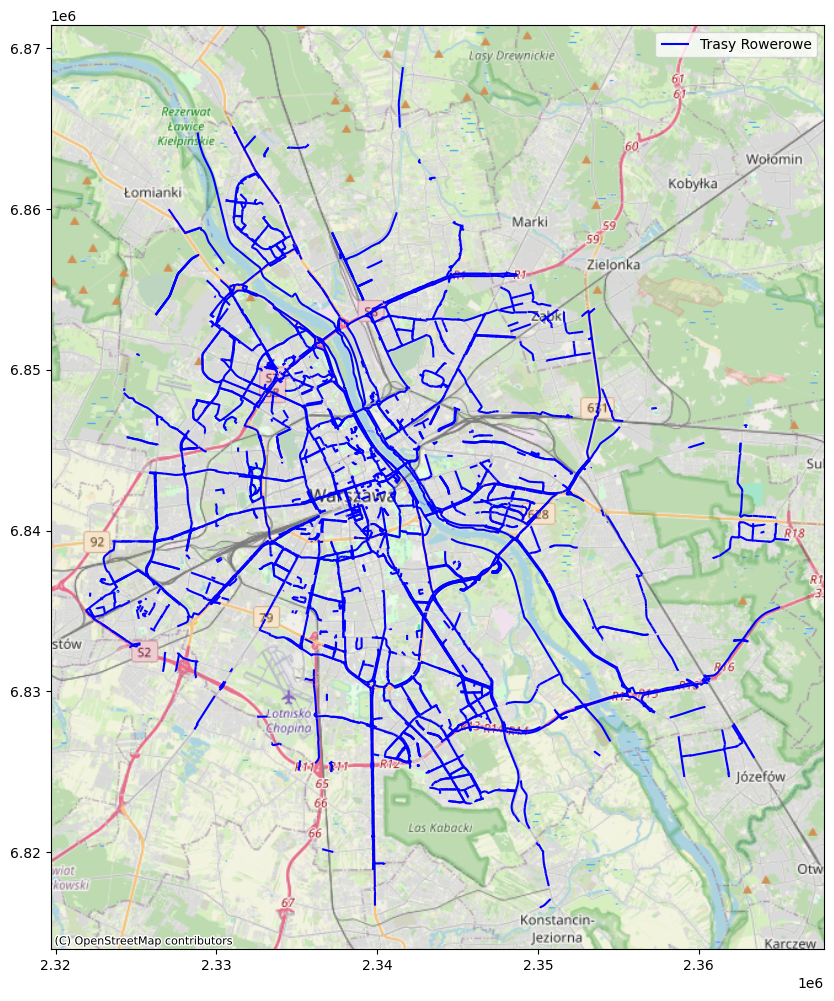

In [131]:
fig, ax = plt.subplots(figsize=(12, 12))
trasy_rowerowe.plot(ax=ax, color='blue', edgecolor='black', label="Trasy Rowerowe")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.legend()
plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_15052\3294002859.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


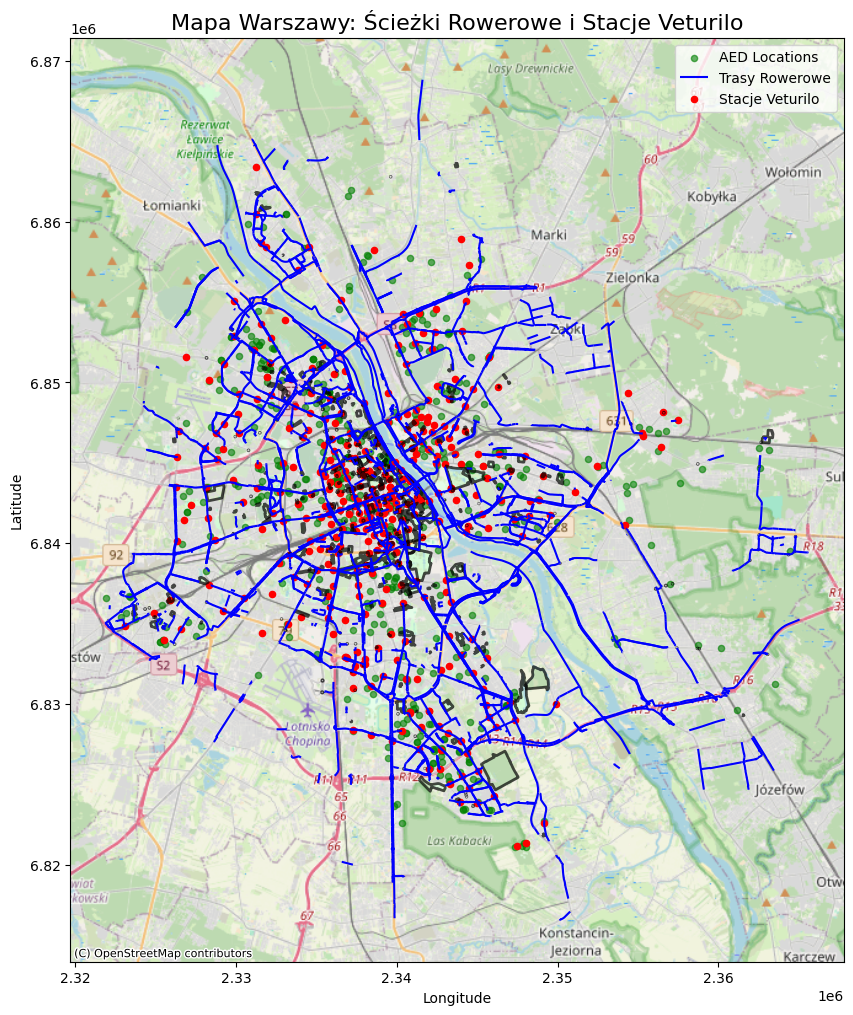

In [110]:

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
aed_gdf.plot(
    ax=ax,
    color='green',
    markersize=20,
    alpha=0.6,
    label='AED Locations'
)
trasy_rowerowe.plot(ax=ax, color='blue', edgecolor='black', label="Trasy Rowerowe")
veturilo.plot(ax=ax, color='red', markersize=20, label="Stacje Veturilo")
enom_gdf.plot(
    ax=ax,
    edgecolor='black',
    facecolor='none',
    linewidth=2,
    alpha=0.7,
    label='Locations'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) 

ax.set_title("Mapa Warszawy: Ścieżki Rowerowe i Stacje Veturilo", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()